# Importación de librerias necesarias

In [1]:
import os
import random

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
import imghdr

In [2]:
### Avoid OOM Errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Remover imagenes no útiles
Asegurarse que todas las imagenes tengan el formato adecuado

In [3]:
DATA_DIR = os.path.abspath('data')
DATA_DIR

'C:\\Users\\julia\\Desktop\\vetlens-ml\\data'

In [4]:
IMAGE_EXTS = ['jpeg', 'jpg', 'bmp', 'png']
for image_class in os.listdir(DATA_DIR):
    for image in os.listdir(os.path.join(DATA_DIR, image_class)):
        image_path = os.path.join(DATA_DIR, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)

            if tip not in IMAGE_EXTS:
                print(f'Image has ext: {tip} not in ext list {image_path}')
                #os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

# Visualización de los datos con los que se está trabajando

In [5]:
class_names = []
img_count = np.array([])
for class_name in os.listdir(os.path.join(DATA_DIR)):
    count = len(os.listdir(os.path.join(DATA_DIR, class_name)))
    class_names.append(class_name)
    img_count = np.append(img_count, count)
class_names,img_count

(['dermatitis_piotraumatica',
  'dermatofitosis',
  'miasis',
  'otra_enfermedad',
  'sin_problemas'],
 array([ 946.,  986.,  879.,  922., 1009.]))

In [6]:
print(f'Mediana de imagenes por clase: {np.median(img_count)}')

Mediana de imagenes por clase: 946.0


Comprobamos que el dataset esta balanceado:

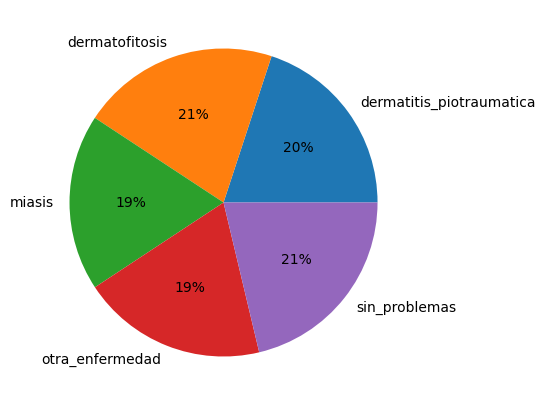

In [7]:
fig = plt.figure(figsize=(5,5))
pie = plt.pie(img_count, labels=class_names, autopct= lambda x: '{:.0f}%'.format(x))
plt.show()

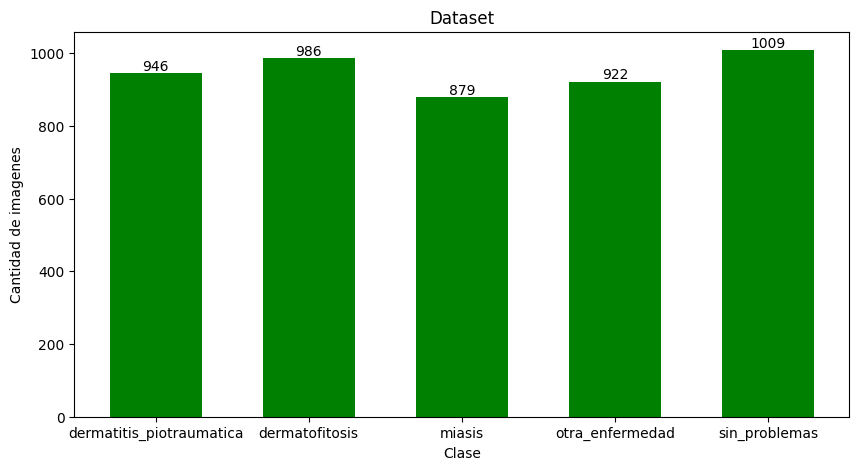

In [8]:
fig = plt.figure(figsize= (10,5))
bars = plt.bar(class_names, img_count, color='green', width=.6)
plt.bar_label(bars)
plt.ylabel('Cantidad de imagenes')
plt.xlabel('Clase')
plt.title('Dataset')
plt.show()

# Aumento de Datos
Dado que el dataset inicial es bastante pequeño, realizaremos operaciones de aumento de datos. De esta forma, se aumenta la cantidad de datos para entrenamiento, prueba y validación y también se disminuye la probabilidad de overfitting.

Primero definimos las transformaciones:

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    zoom_range=.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)

In [10]:
def augment (x, dir, prefix):
    i = 0
    for batch in datagen.flow(x, batch_size=32, save_to_dir=dir, save_prefix=prefix, save_format='jpeg'):
        i +=1
        if i > 20: # paramos la cantidad de transformaciones para evitar que sean infinitas
            break

In [11]:
def process_image(image_path, img_size=224):

  """
  Toma la ruta de una imagen y la devuelve como un Tensor
  """

  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

In [12]:
derm_dir = [os.path.abspath(os.path.join('data','dermatofitosis', fname)) for fname in os.listdir(os.path.abspath(os.path.join('data','dermatofitosis')))]
pio_dir = [os.path.abspath(os.path.join('data','dermatitis_piotraumatica', fname)) for fname in os.listdir(os.path.abspath(os.path.join('data','dermatitis_piotraumatica')))]
mia_dir = [os.path.abspath(os.path.join('data','miasis', fname)) for fname in os.listdir(os.path.abspath(os.path.join('data','miasis')))]
sin_prob_dir = [os.path.abspath(os.path.join('data','sin_problemas', fname)) for fname in os.listdir(os.path.abspath(os.path.join('data','sin_problemas')))]
otras_dir = [os.path.abspath(os.path.join('data','otra_enfermedad', fname)) for fname in os.listdir(os.path.abspath(os.path.join('data','otra_enfermedad')))]

In [13]:
derm = tf.data.Dataset.from_tensor_slices(tf.constant(derm_dir))
derm_batch = derm.map(process_image).batch(32)
pio = tf.data.Dataset.from_tensor_slices(tf.constant(pio_dir))
pio_batch = pio.map(process_image).batch(32)
mia = tf.data.Dataset.from_tensor_slices(tf.constant(mia_dir))
mia_batch = mia.map(process_image).batch(32)
sin_prob = tf.data.Dataset.from_tensor_slices(tf.constant(sin_prob_dir))
sin_prob_batch = sin_prob.map(process_image).batch(32)
otra = tf.data.Dataset.from_tensor_slices(tf.constant(otras_dir))
otra_batch = otra.map(process_image).batch(32)

derm_batch, pio_batch, mia_batch

(<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>,
 <BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>,
 <BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>)

In [14]:
for img in derm_batch.as_numpy_iterator():
    augment(img, os.path.join('data','dermatofitosis'), 'dermatofitosis')
for img in pio_batch.as_numpy_iterator():
    augment(img, os.path.join('data','dermatitis_piotraumatica'), 'piotraumatica')
for img in mia_batch.as_numpy_iterator():
    augment(img, os.path.join('data','miasis'), 'miasis')
for img in sin_prob_batch.as_numpy_iterator():
    augment(img, os.path.join('data','sin_problemas'), 'sin_problemas')
for img in otra_batch.as_numpy_iterator():
    augment(img, os.path.join('data','otra_enfermedad'), 'otra_enfermedad')

NameError: name 'scipy' is not defined

# Comenzamos a trabajar con los datos

In [15]:
IMAGE_SIZE = 224
INPUT_SHAPE = (None, IMAGE_SIZE, IMAGE_SIZE, 3)
SEED = random.randint(0,10000000)
SEED

3285497

In [16]:
training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    label_mode='categorical',
    color_mode='rgb',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    shuffle=True,
    seed=SEED,
    validation_split=.2,
    subset='both',
    interpolation='bicubic')

Found 4742 files belonging to 5 classes.
Using 3794 files for training.
Using 948 files for validation.


In [17]:
training_dataset, validation_dataset

(<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

In [18]:
diseases = training_dataset.class_names

In [19]:
batch_train = training_dataset.as_numpy_iterator().next()
batch_val = validation_dataset.as_numpy_iterator().next()

In [20]:
def print_first_10(batch, has_labels=True):
    """
    Imprime las primeras 10 imagenes de un batch de imagenes, y si poseen labels, las labels respectivas
    :param batch: a batch of images
    :return: None
    """
    fig, ax = plt.subplots(ncols=10, figsize=(20,20))
    for idx, img in enumerate(batch[0][:10]):
        ax[idx].imshow(img.astype(int))
        if has_labels:
            ax[idx].title.set_text(diseases[np.argmax(batch[1][idx])])

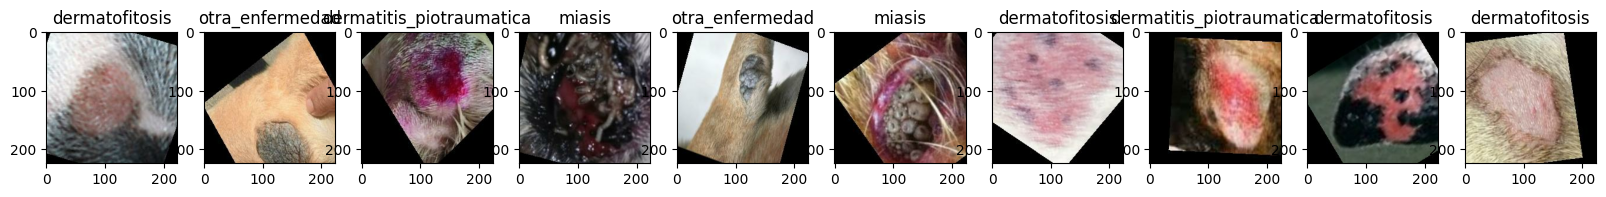

In [21]:
print_first_10(batch_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


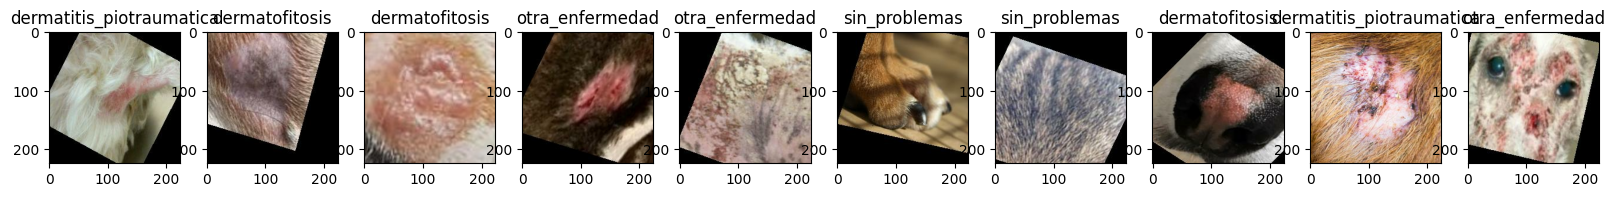

In [22]:
print_first_10(batch_val)

Debemos normalizar las imágenes, es decir, transformar los valores de los pixeles que van de 0 - 255, para que vayan de 0 - 1:

In [23]:

#training_dataset = training_dataset.map(lambda x, y: (x/255, y))
#validation_dataset = validation_dataset.map(lambda x, y: (x/255, y))
#training_dataset, validation_dataset

# Pruebas con diferentes modelos base

Dado que estaremos utilizando transfer learning, tenemos que encontrar que modelo tiene un mejor rendimiento para el problema que intentamos resolver. Para ello se probarán los siguientes modelos: ResNet50, Xception, VGG16 y EfficientNetB2. Puesto que estos modelos tienen una alta complejidad, no se quiere agregar demasiadas capas, puesto que esto podría transformarse un detrimento para el rendimiento.

Cada modelo tiene diferentes requerimientos para sus inputs, por ende lo primero será ajustarse a ello.


## Rendimiento ResNet50

In [24]:
resnet_train_ds = training_dataset.map(lambda x,y: (tf.keras.applications.resnet.preprocess_input(x), y))
resnet_vald_ds = validation_dataset.map(lambda x,y: (tf.keras.applications.resnet.preprocess_input(x), y))

In [25]:
base_model = tf.keras.applications.ResNet50(include_top=False,
                                            weights='imagenet',
                                            input_shape=(224, 224 ,3))
base_model.trainable = False

model_resnet = tf.keras.Sequential()

model_resnet.add(base_model)

model_resnet.add(tf.keras.layers.Flatten())
model_resnet.add(tf.keras.layers.Dense(5, activation='softmax'))


94765736/94765736 [==============================] - 5s 0us/step


In [26]:
model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 5)                 501765    
                                                                 
Total params: 24,089,477
Trainable params: 501,765
Non-trainable params: 23,587,712
_________________________________________________________________


In [27]:
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [28]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## Entrenamiento modelo ResNet

Definimos early_stopping para evitar que el modelo haga overfitting:

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [30]:
hist_resnet = model_resnet.fit(training_dataset, epochs=30, validation_data=validation_dataset, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/30
119/119 [==============================] - 48s 364ms/step - loss: 1.7773 - accuracy: 0.4241 - val_loss: 1.1409 - val_accuracy: 0.5675
Epoch 2/30
119/119 [==============================] - 42s 349ms/step - loss: 0.7848 - accuracy: 0.7019 - val_loss: 0.7884 - val_accuracy: 0.6867
Epoch 3/30
119/119 [==============================] - 42s 350ms/step - loss: 0.4752 - accuracy: 0.8234 - val_loss: 0.6317 - val_accuracy: 0.7500
Epoch 4/30
119/119 [==============================] - 42s 348ms/step - loss: 0.3078 - accuracy: 0.8983 - val_loss: 0.5409 - val_accuracy: 0.7922
Epoch 5/30
119/119 [==============================] - 41s 348ms/step - loss: 0.2102 - accuracy: 0.9420 - val_loss: 0.4859 - val_accuracy: 0.8112
Epoch 6/30
119/119 [==============================] - 41s 342ms/step - loss: 0.1502 - accuracy: 0.9713 - val_loss: 0.4439 - val_accuracy: 0.8333
Epoch 7/30
119/119 [==============================] - 41s 341ms/step - loss: 0.1110 - accuracy: 0.9863 - val_loss: 0.4160 - val_ac

## Métricas del modelo ResNet

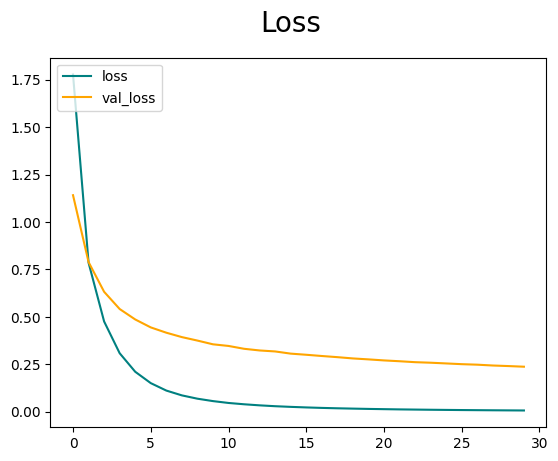

In [31]:
fig = plt.figure()
plt.plot(hist_resnet.history['loss'], color='teal', label='loss')
plt.plot(hist_resnet.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

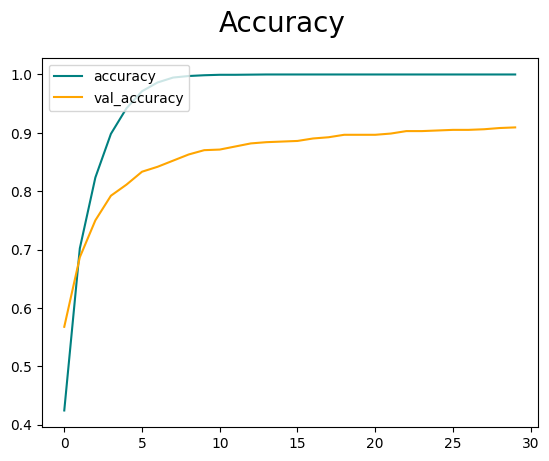

In [32]:
fig = plt.figure()
plt.plot(hist_resnet.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_resnet.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Rendimiento Xception

In [33]:
xception_train_ds = training_dataset.map(lambda x,y: (tf.keras.applications.xception.preprocess_input(x), y))
xception_vald_ds = validation_dataset.map(lambda x,y: (tf.keras.applications.xception.preprocess_input(x), y))

In [34]:
base_model = tf.keras.applications.Xception(include_top=False,
                                            weights='imagenet',
                                            input_shape=(224, 224 ,3))
base_model.trainable = False

model_xception = tf.keras.Sequential()

model_xception.add(base_model)

model_xception.add(tf.keras.layers.Flatten())
model_xception.add(tf.keras.layers.Dense(5, activation='softmax'))


83683744/83683744 [==============================] - 5s 0us/step


In [35]:
model_xception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_1 (Dense)             (None, 5)                 501765    
                                                                 
Total params: 21,363,245
Trainable params: 501,765
Non-trainable params: 20,861,480
_________________________________________________________________


In [36]:
model_xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [37]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## Entrenamiento modelo Xception

Definimos early_stopping para evitar que el modelo haga overfitting:

In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [39]:
hist_xception = model_xception.fit(training_dataset, epochs=30, validation_data=validation_dataset, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/30
119/119 [==============================] - 80s 654ms/step - loss: 10.9461 - accuracy: 0.2775 - val_loss: 8.1300 - val_accuracy: 0.3513
Epoch 2/30
119/119 [==============================] - 79s 661ms/step - loss: 7.1475 - accuracy: 0.3672 - val_loss: 6.7877 - val_accuracy: 0.3734
Epoch 3/30
119/119 [==============================] - 79s 662ms/step - loss: 5.3224 - accuracy: 0.4280 - val_loss: 5.6997 - val_accuracy: 0.4019
Epoch 4/30
119/119 [==============================] - 79s 663ms/step - loss: 4.3267 - accuracy: 0.4805 - val_loss: 5.3988 - val_accuracy: 0.4072
Epoch 5/30
119/119 [==============================] - 79s 662ms/step - loss: 3.5228 - accuracy: 0.5203 - val_loss: 4.9764 - val_accuracy: 0.4357
Epoch 6/30
119/119 [==============================] - 78s 656ms/step - loss: 2.9249 - accuracy: 0.5672 - val_loss: 4.5688 - val_accuracy: 0.4589
Epoch 7/30
119/119 [==============================] - 75s 627ms/step - loss: 2.5052 - accuracy: 0.5886 - val_loss: 4.7844 - val_a

## Métricas del modelo Xception

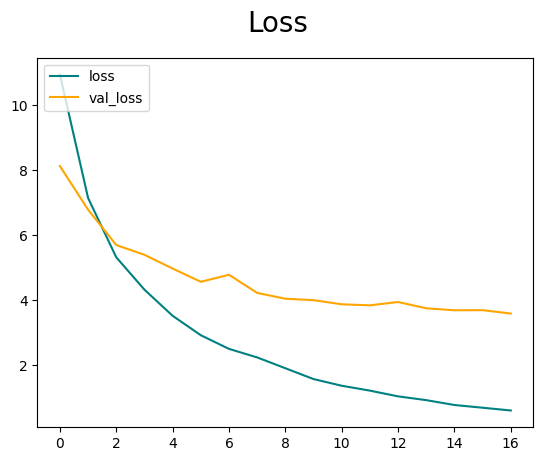

In [40]:
fig = plt.figure()
plt.plot(hist_xception.history['loss'], color='teal', label='loss')
plt.plot(hist_xception.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

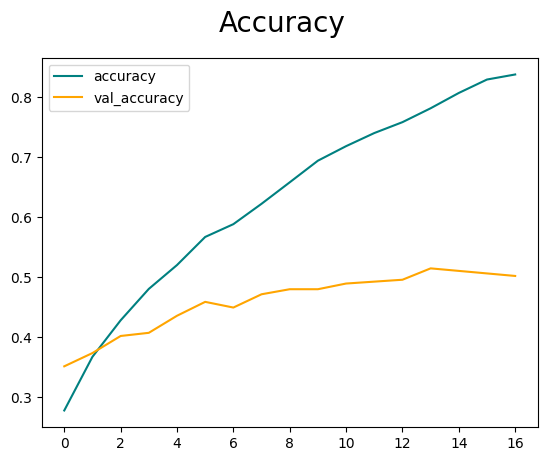

In [41]:
fig = plt.figure()
plt.plot(hist_xception.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_xception.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Rendimiento VGG16

In [42]:
vgg16_train_ds = training_dataset.map(lambda x,y: (tf.keras.applications.vgg16.preprocess_input(x), y))
vgg16_vald_ds = validation_dataset.map(lambda x,y: (tf.keras.applications.vgg16.preprocess_input(x), y))

In [43]:
base_model = tf.keras.applications.VGG16(include_top=False,
                                            weights='imagenet',
                                            input_shape=(224, 224 ,3))
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()

model_vgg16.add(base_model)

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(5, activation='softmax'))


58889256/58889256 [==============================] - 4s 0us/step


In [44]:
model_vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 5)                 125445    
                                                                 
Total params: 14,840,133
Trainable params: 125,445
Non-trainable params: 14,714,688
_________________________________________________________________


In [45]:
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [46]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## Entrenamiento modelo VGG16

Definimos early_stopping para evitar que el modelo haga overfitting:

In [47]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [48]:
hist_vgg16 = model_vgg16.fit(training_dataset, epochs=30, validation_data=validation_dataset, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/30
119/119 [==============================] - 60s 498ms/step - loss: 9.7705 - accuracy: 0.2478 - val_loss: 7.9121 - val_accuracy: 0.2943
Epoch 2/30
119/119 [==============================] - 59s 496ms/step - loss: 6.9912 - accuracy: 0.3495 - val_loss: 6.2510 - val_accuracy: 0.3470
Epoch 3/30
119/119 [==============================] - 59s 498ms/step - loss: 5.3658 - accuracy: 0.4346 - val_loss: 5.2690 - val_accuracy: 0.4167
Epoch 4/30
119/119 [==============================] - 59s 498ms/step - loss: 4.2386 - accuracy: 0.5008 - val_loss: 4.6405 - val_accuracy: 0.4736
Epoch 5/30
119/119 [==============================] - 59s 497ms/step - loss: 3.4218 - accuracy: 0.5640 - val_loss: 4.1921 - val_accuracy: 0.5105
Epoch 6/30
119/119 [==============================] - 59s 497ms/step - loss: 2.7966 - accuracy: 0.6165 - val_loss: 3.8483 - val_accuracy: 0.5359
Epoch 7/30
119/119 [==============================] - 59s 497ms/step - loss: 2.3097 - accuracy: 0.6629 - val_loss: 3.6059 - val_ac

## Métricas del modelo VGG16

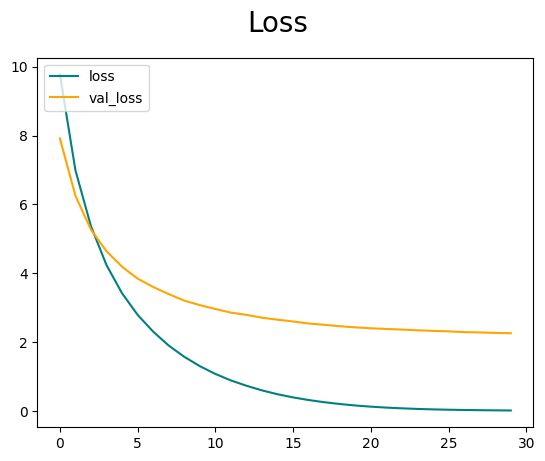

In [49]:
fig = plt.figure()
plt.plot(hist_vgg16.history['loss'], color='teal', label='loss')
plt.plot(hist_vgg16.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

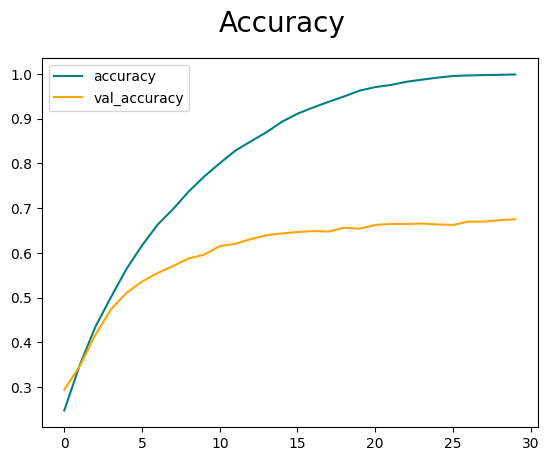

In [50]:
fig = plt.figure()
plt.plot(hist_vgg16.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_vgg16.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Rendimiento EfficientNetB2

In [51]:
base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                                            weights='imagenet',
                                            input_shape=(224, 224 ,3))
base_model.trainable = False

model_efficientnetb2 = tf.keras.Sequential()

model_efficientnetb2.add(base_model)

model_efficientnetb2.add(tf.keras.layers.Flatten())
model_efficientnetb2.add(tf.keras.layers.Dense(5, activation='softmax'))


31790344/31790344 [==============================] - 27s 1us/step


In [52]:
model_efficientnetb2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten_3 (Flatten)         (None, 68992)             0         
                                                                 
 dense_3 (Dense)             (None, 5)                 344965    
                                                                 
Total params: 8,113,534
Trainable params: 344,965
Non-trainable params: 7,768,569
_________________________________________________________________


In [53]:
model_efficientnetb2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [54]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## Entrenamiento modelo EfficientNetB2

Definimos early_stopping para evitar que el modelo haga overfitting:

In [55]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [56]:
hist_efficientnetb2 = model_efficientnetb2.fit(training_dataset, epochs=30, validation_data=validation_dataset, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/30
119/119 [==============================] - 66s 489ms/step - loss: 1.3413 - accuracy: 0.4623 - val_loss: 0.8907 - val_accuracy: 0.6646
Epoch 2/30
119/119 [==============================] - 56s 472ms/step - loss: 0.7518 - accuracy: 0.7251 - val_loss: 0.6446 - val_accuracy: 0.7743
Epoch 3/30
119/119 [==============================] - 56s 474ms/step - loss: 0.5482 - accuracy: 0.8129 - val_loss: 0.5159 - val_accuracy: 0.8249
Epoch 4/30
119/119 [==============================] - 57s 475ms/step - loss: 0.4277 - accuracy: 0.8724 - val_loss: 0.4359 - val_accuracy: 0.8492
Epoch 5/30
119/119 [==============================] - 57s 475ms/step - loss: 0.3418 - accuracy: 0.9062 - val_loss: 0.3812 - val_accuracy: 0.8745
Epoch 6/30
119/119 [==============================] - 57s 475ms/step - loss: 0.2862 - accuracy: 0.9325 - val_loss: 0.3435 - val_accuracy: 0.8850
Epoch 7/30
119/119 [==============================] - 57s 475ms/step - loss: 0.2468 - accuracy: 0.9449 - val_loss: 0.3111 - val_ac

## Métricas del modelo EfficientNetB2

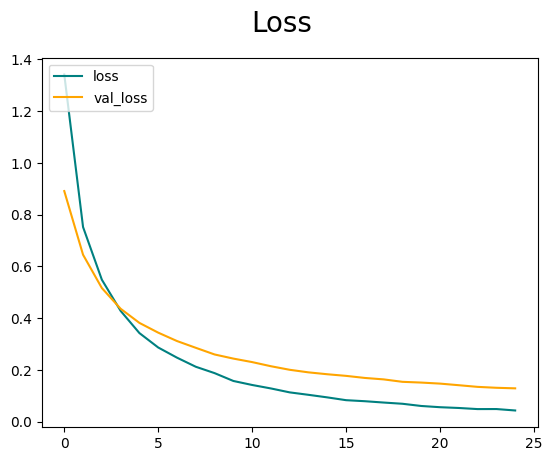

In [57]:
fig = plt.figure()
plt.plot(hist_efficientnetb2.history['loss'], color='teal', label='loss')
plt.plot(hist_efficientnetb2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

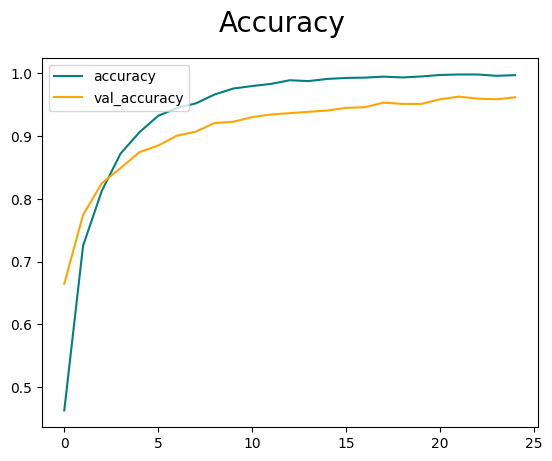

In [58]:
fig = plt.figure()
plt.plot(hist_efficientnetb2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist_efficientnetb2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# Predicciones

In [59]:
prediction_resnet = model_resnet.predict(validation_dataset)
prediction_xception = model_xception.predict(validation_dataset)
prediction_vgg16 = model_vgg16.predict(validation_dataset)
prediction_efficientnetb2 = model_efficientnetb2.predict(validation_dataset)

30/30 [==============================] - 13s 369ms/step


In [60]:
images = []
labels = []
for image, label in validation_dataset.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(diseases[np.argmax(label)])

In [61]:
def plot_pred(prediction_probabilities, labels_p, images_p, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image_v = prediction_probabilities[n], labels_p[n], images_p[n]
  # Get the pred label
  pred_label = diseases[np.argmax(pred_prob)]

  # Plot image and remove ticks
  plt.imshow(image_v)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong.

  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change the plot title to be predicted label, probability of prediction and truth label.
  plt.title("{} {:2.0f}% {}".format(pred_label, np.max(pred_prob)*100, true_label), color=color)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


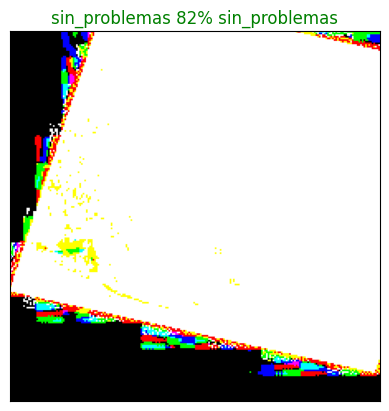

In [62]:
plot_pred(prediction_resnet, labels, images, n=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


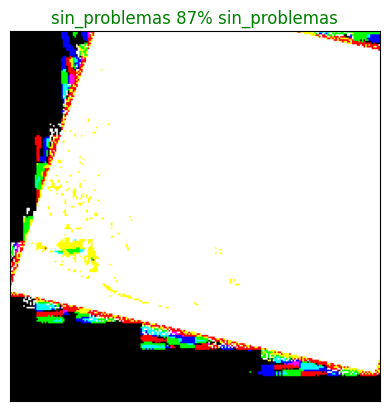

In [63]:
plot_pred(prediction_xception, labels, images, n=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


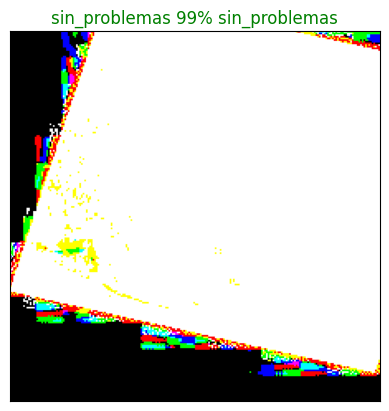

In [64]:
plot_pred(prediction_vgg16, labels, images, n=5)

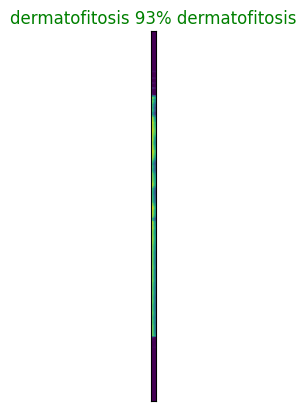

In [77]:
plot_pred(prediction_efficientnetb2, labels, image, n=10)

In [66]:
def plot_pred_conf(prediction_probabilities, labels_x, n=1):
  """
  Plot the top 10 highest prediction confidences along with the truth label for sample n
  """
  pred_prob, true_label = prediction_probabilities[n], labels_x[n]

  # Get the predicted label

  pred_label = diseases[np.argmax(pred_prob)]

  # Find the top 10 prediction confidence indexes

  top_3_pred_indexes = pred_prob.argsort()# En orden descendente
  # Find the top 10 prediction confidence values
  top_3_pred_values = pred_prob[top_3_pred_indexes]

  # Find the top 10 prediction labels

  top_3_pred_labels = np.array(diseases)[top_3_pred_indexes]

  # Setup plot

  top_plot = plt.bar(np.arange(len(top_3_pred_labels)), top_3_pred_values, color="grey")
  plt.xticks(np.arange(len(top_3_pred_labels)), labels=top_3_pred_labels, rotation="vertical")

  # Change color of the true label

  if np.isin(true_label, top_3_pred_indexes):
    top_plot[np.argmax(top_3_pred_indexes == true_label)].set_color("green")
  else:
    pass

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\julia\anaconda3\envs\backup\lib\site-packages\numpy\lib\arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


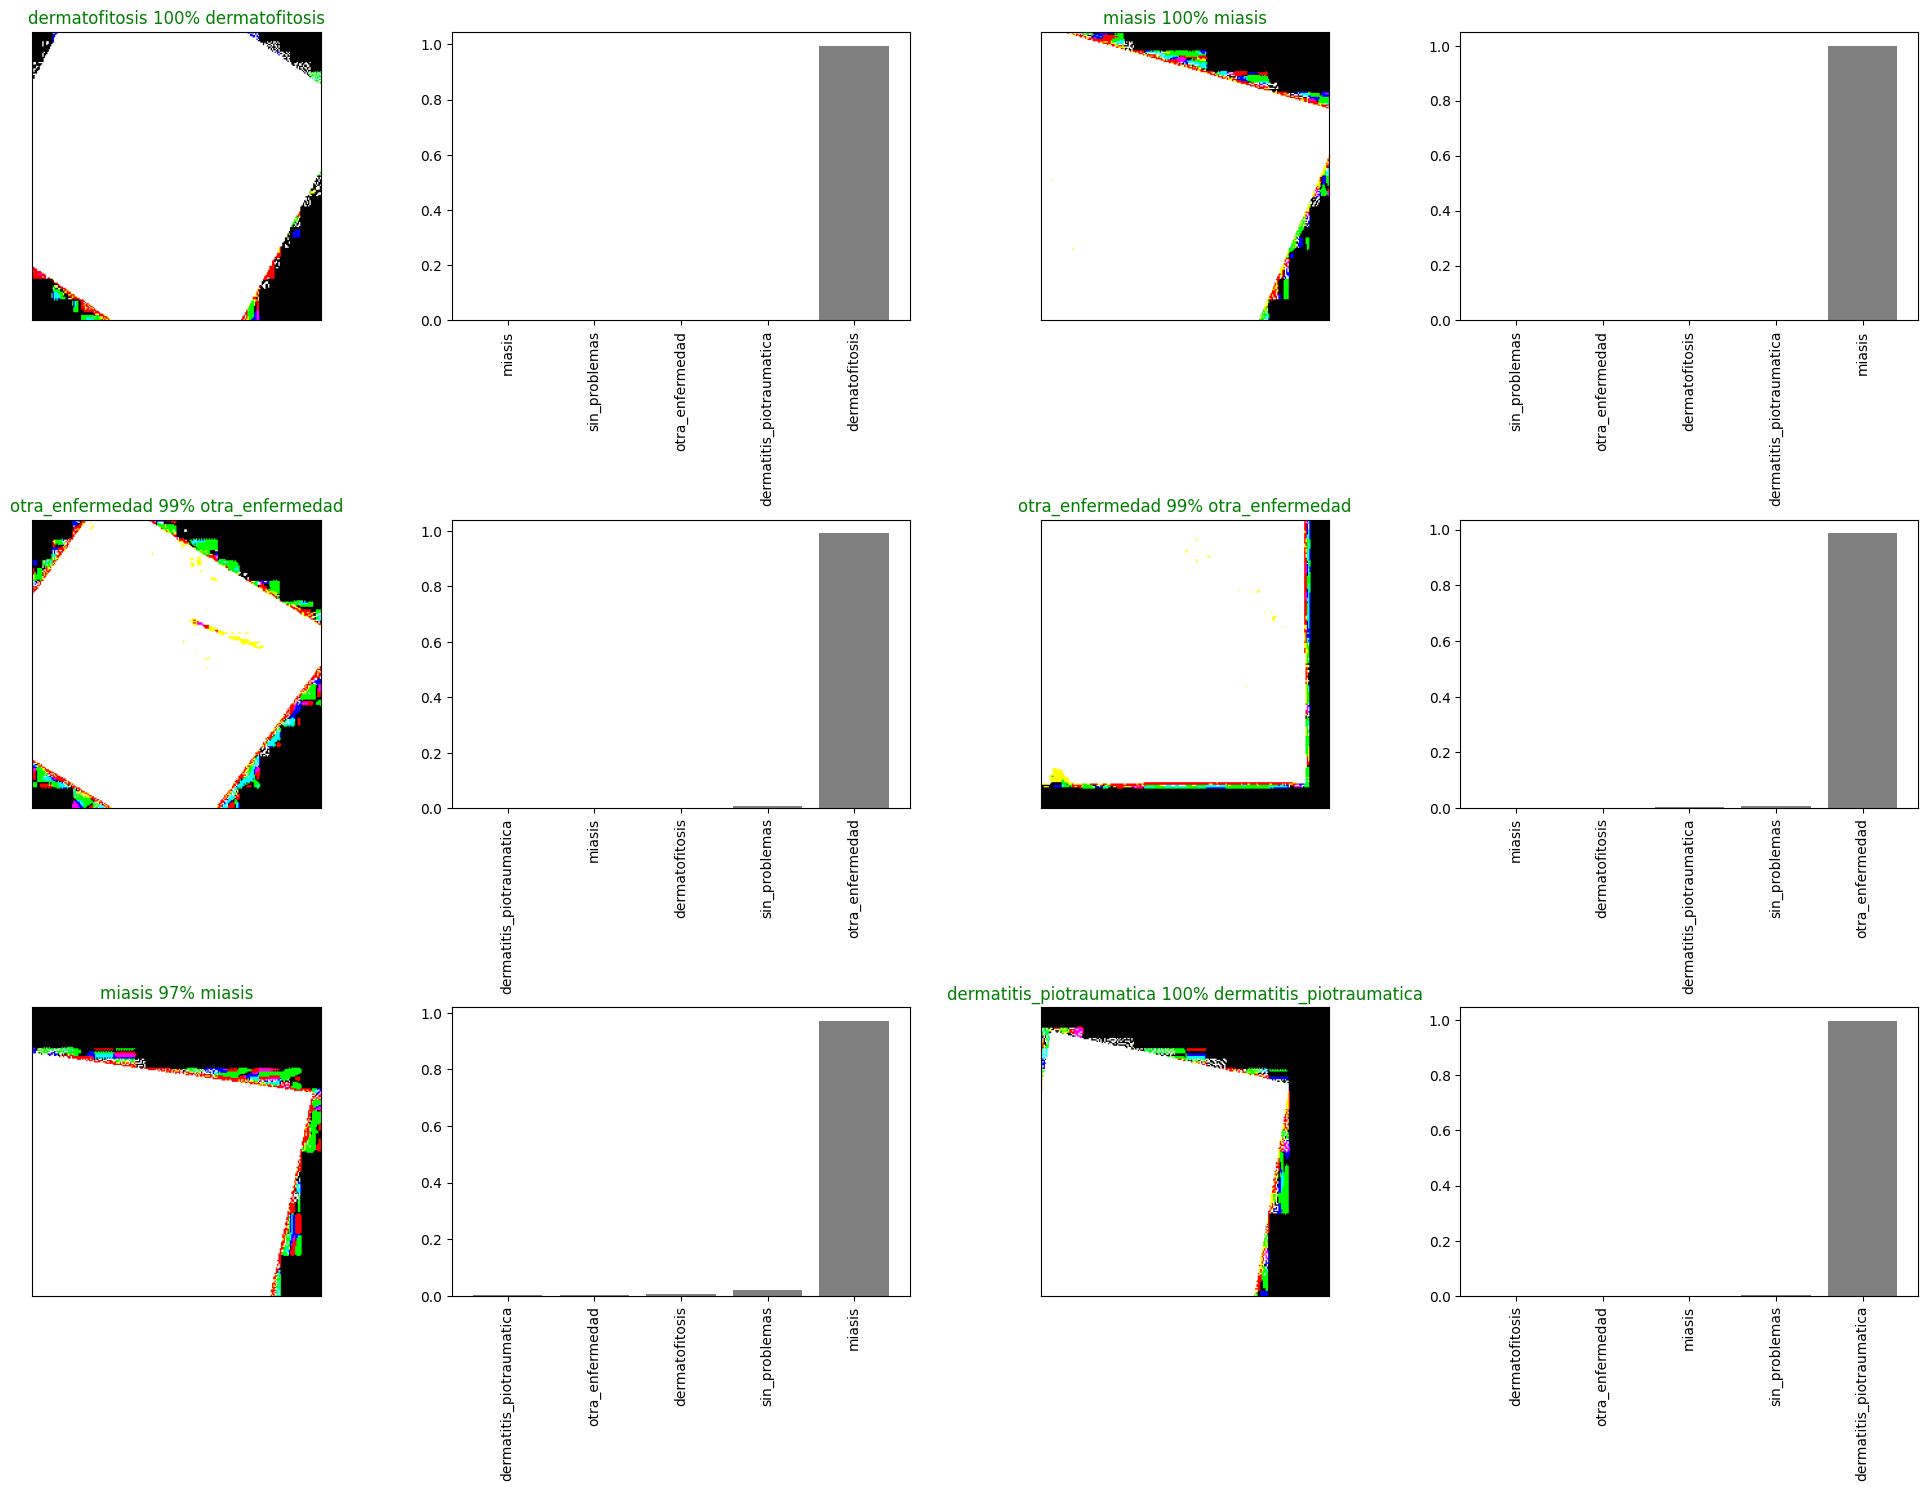

In [67]:
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range (num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=prediction_resnet, labels_p=labels, images_p=images, n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_resnet, labels, n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


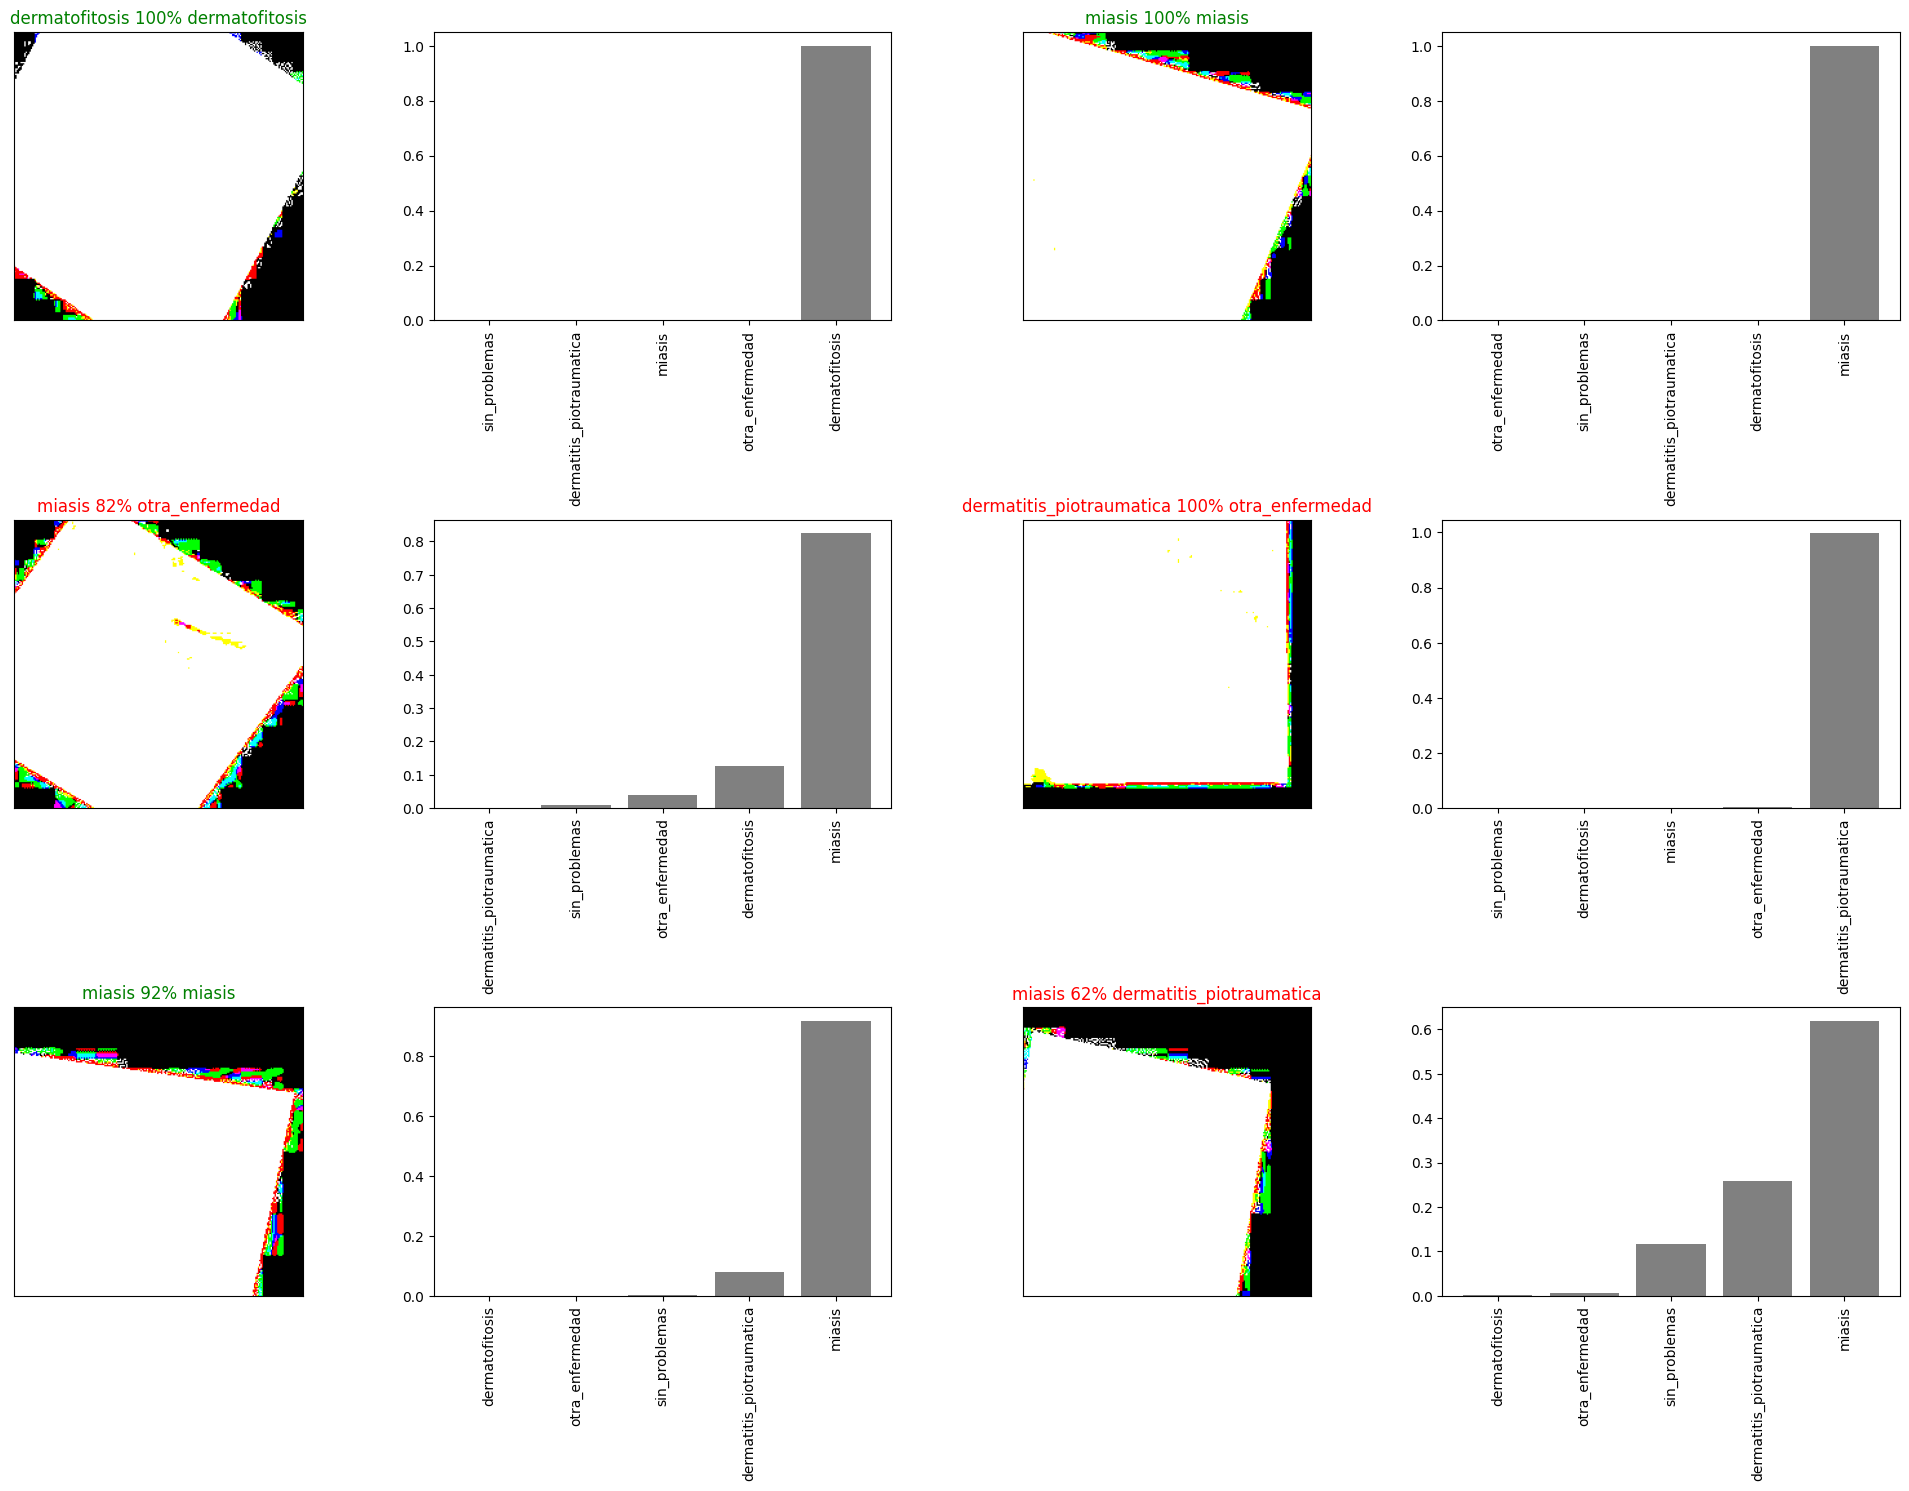

In [68]:
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range (num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=prediction_xception, labels_p=labels, images_p=images, n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_xception, labels, n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


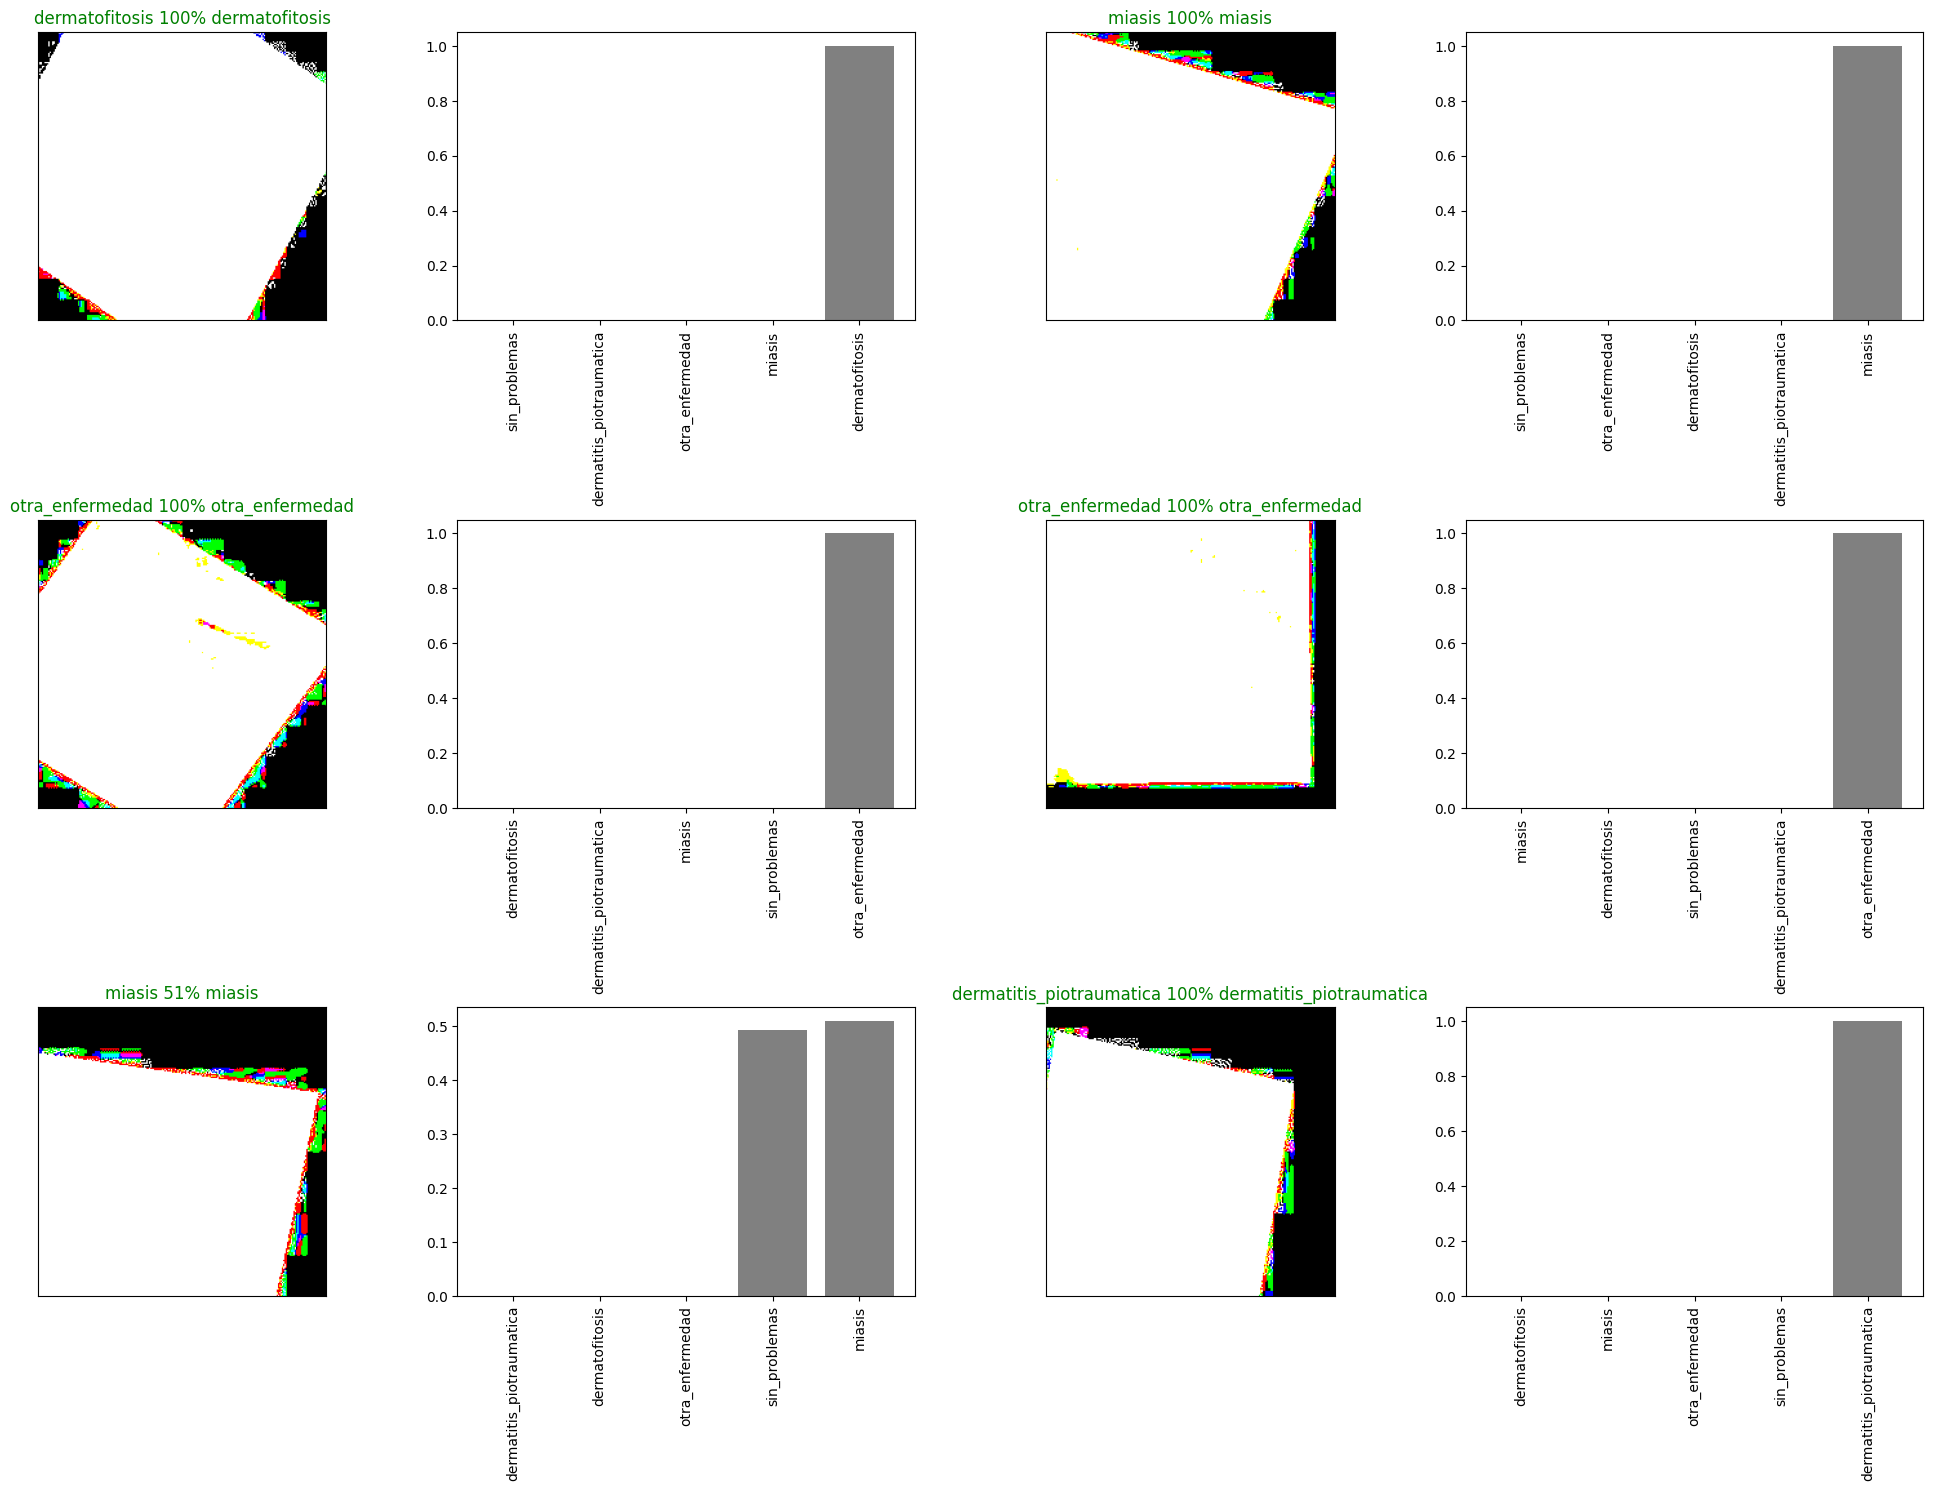

In [69]:
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range (num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=prediction_vgg16, labels_p=labels, images_p=images, n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_vgg16, labels, n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


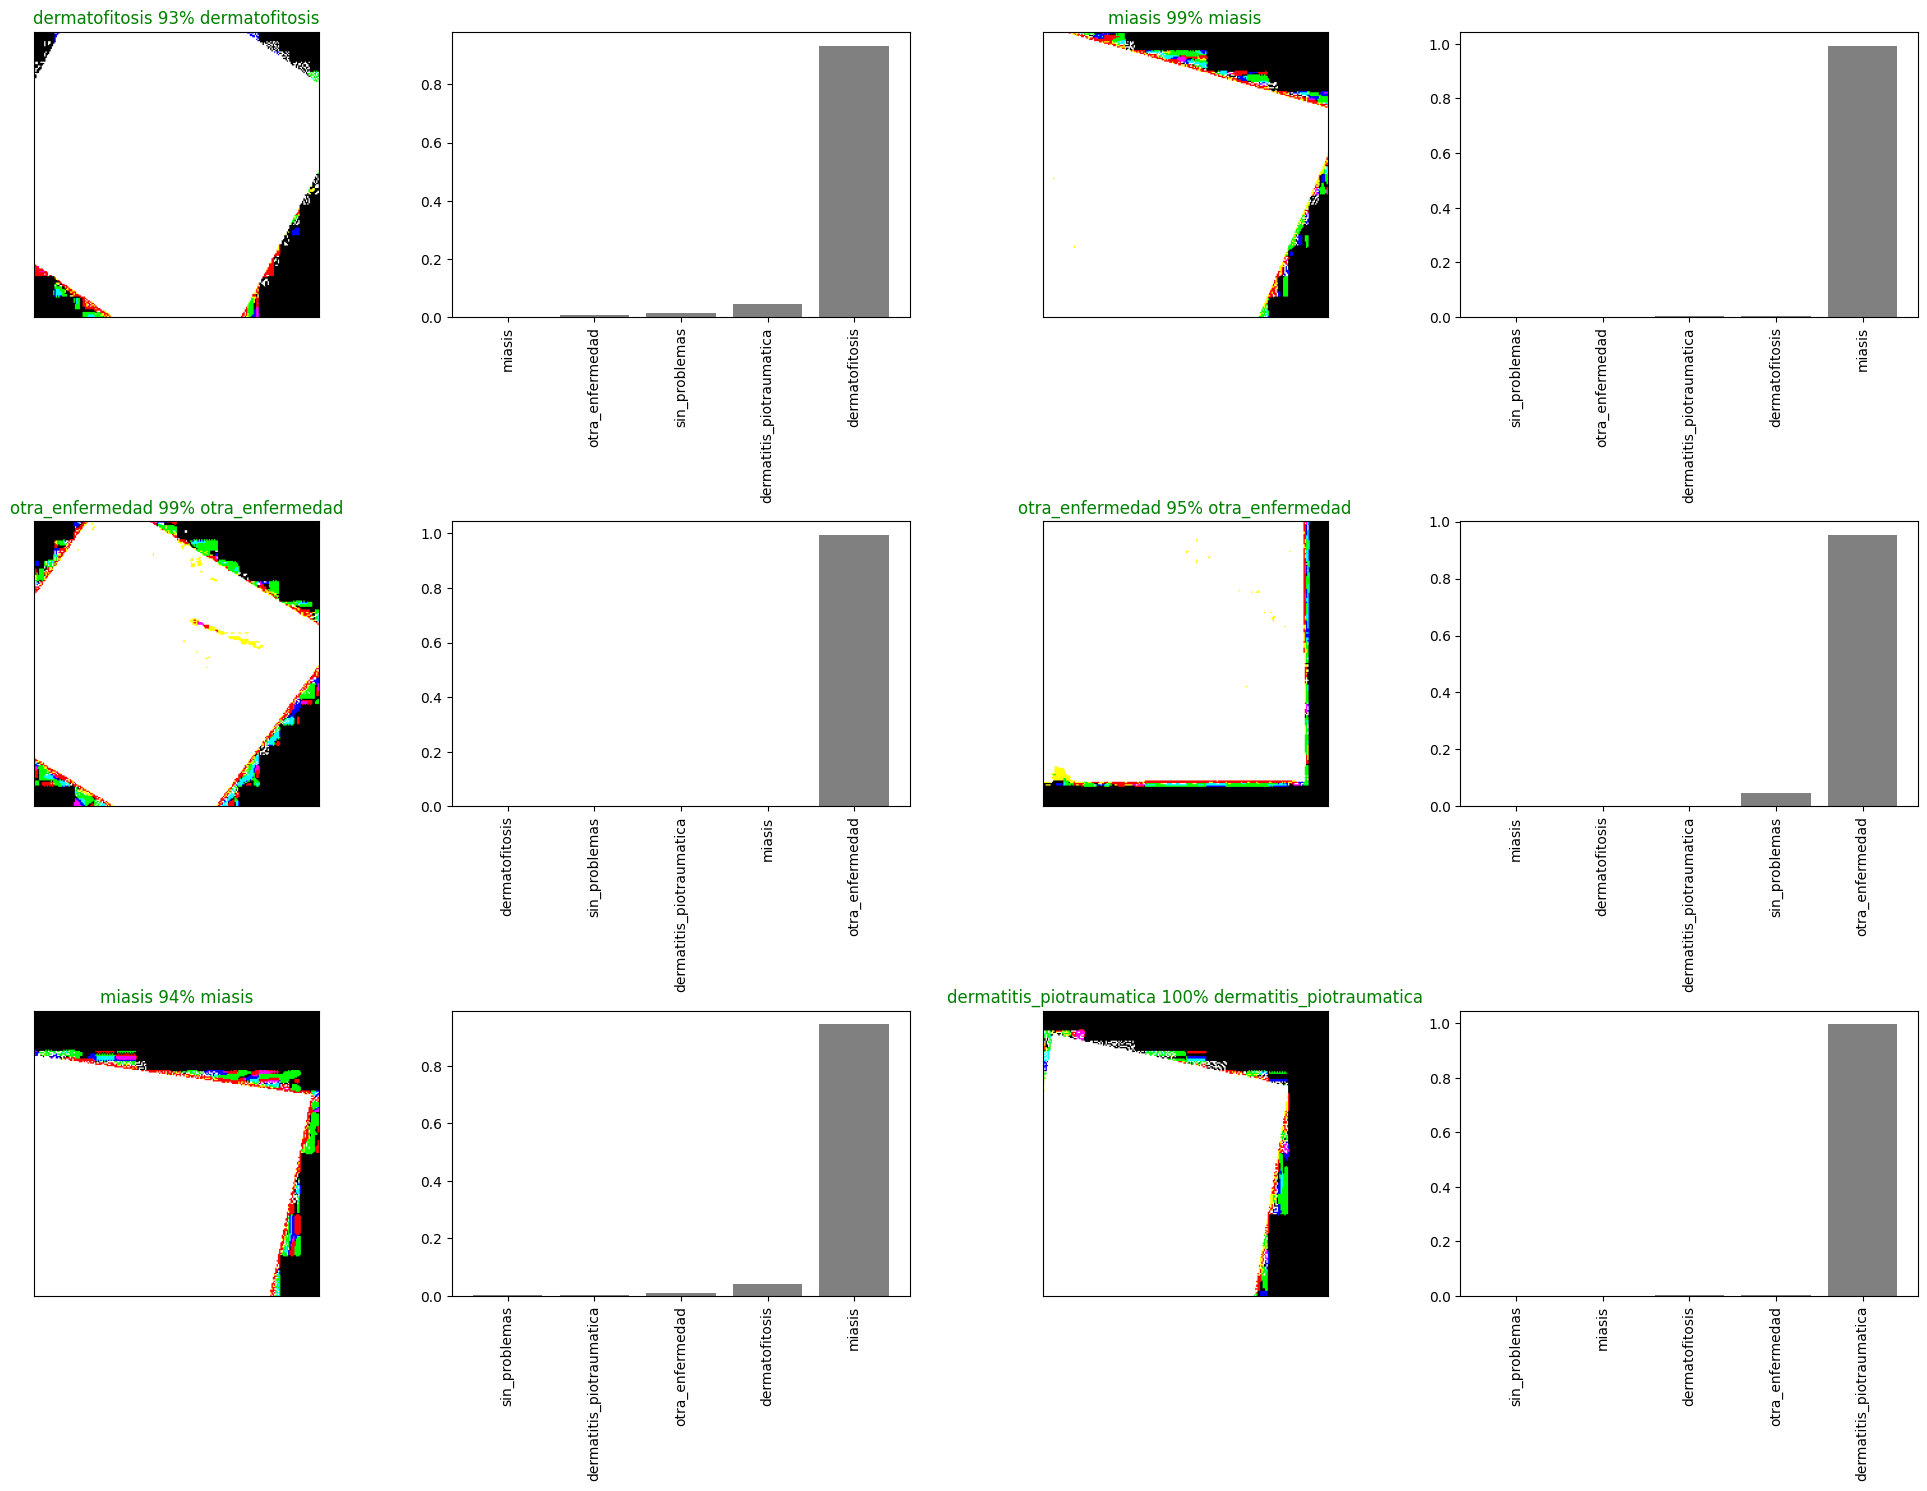

In [70]:
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range (num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=prediction_efficientnetb2, labels_p=labels, images_p=images, n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_efficientnetb2, labels, n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [71]:
def get_test_img_paths_with_labels(testing_dir='testing'):
    test_img_paths = []
    test_labels = []

    for folder_name in os.listdir(testing_dir):
        for file_name in os.listdir(os.path.join(testing_dir, folder_name)):
            test_img_paths.append(os.path.abspath(os.path.join(testing_dir, folder_name, file_name)))
            test_labels.append(folder_name)

    return test_img_paths, test_labels

In [72]:
def make_prediction(images_paths, model_to_use='trained'):
    dataset = tf.data.Dataset.from_tensor_slices(tf.constant(images_paths))
    dataset_batch = dataset.map(process_image).batch(32)
    if model_to_use == 'xception':
        ## 4 clases
        xception_model = tf.keras.models.load_model((os.path.join('models', 'dogsskindiseaseswithother_v1_xception.h5')))
        predictions = xception_model.predict(dataset_batch)
    elif model_to_use == 'vgg16':
        ## 3 clases
        vgg16_model = tf.keras.models.load_model((os.path.join('models', 'dogsskindiseaseswithother_v1.h5')))
        predictions = vgg16_model.predict(dataset_batch)
    elif model_to_use == 'trained':
        predictions = model.predict(dataset_batch)
    else:
        print('There is no such model!')
        return
    return predictions

In [73]:
def print_text_pred_5_classes(predictions, test_image_paths, test_lbls):
    accurate_pred = 0
    total_pred = len(test_image_paths)
    file_names = [fname.split('\\')[-1] for fname in test_image_paths]

    for idx, img in enumerate(file_names):
        pred_res = diseases[np.argmax(predictions[idx])]
        if pred_res == test_lbls[idx] or pred_res == 'sin_problemas' and test_lbls[idx] == 'otra_enfermedad' or pred_res == 'otra_enfermedad' and test_lbls[idx] == 'sin_problemas':
            accurate_pred += 1
        print(f'Prediction for image: {img} is \'{diseases[np.argmax(predictions[idx])]}\' with a {predictions[idx][np.argmax(predictions[idx])]*100:.2f}%. True class: {test_lbls[idx]}.\nResults: \'dermatofitosis\': {predictions[idx][1]*100:.2f}%, \'piotraumatica\': {predictions[idx][0]*100:.2f}%, \'miasis\': {predictions[idx][2]*100:.2f}%, \'otras\': {predictions[idx][3]*100:.2f}%, \'sano\': {predictions[idx][4]*100:.2f}%\n=====================================')
    print(f'Precision: {(accurate_pred/total_pred)*100}')

In [74]:
def print_text_pred_4_classes(predictions, test_image_paths, test_lbls):
    accurate_pred = 0
    total_pred = len(test_image_paths)
    file_names = [fname.split('\\')[-1] for fname in test_image_paths]

    for idx, img in enumerate(file_names):
        pred_res = diseases[np.argmax(predictions[idx])]
        if pred_res == test_lbls[idx] or pred_res == 'otra_enfermedad' and test_lbls[idx] == 'sin_problemas':
            accurate_pred += 1
        print(f'Prediction for image: {img} is \'{diseases[np.argmax(predictions[idx])]}\' with a {predictions[idx][np.argmax(predictions[idx])]*100:.2f}%. True class: {test_lbls[idx]}.\nResults: \'dermatofitosis\': {predictions[idx][1]*100:.2f}%, \'piotraumatica\': {predictions[idx][0]*100:.2f}%, \'miasis\': {predictions[idx][2]*100:.2f}%, \'otras\': {predictions[idx][3]*100:.2f}%\n=====================================')
    print(f'Precision: {(accurate_pred/total_pred)*100}')

In [75]:
test_img_paths, test_labels = get_test_img_paths_with_labels(testing_dir='testing')
predictions_xception = make_prediction(test_img_paths, model_to_use='xception')
predictions_trained = make_prediction(test_img_paths, model_to_use='trained')

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'testing'

In [ ]:
print_text_pred_4_classes(predictions_xception, test_image_paths=test_img_paths, test_lbls=test_labels)
print_text_pred_5_classes(predictions_trained, test_image_paths=test_img_paths, test_lbls=test_labels)

In [ ]:
#model.save(os.path.join('models', 'dogsskindiseaseswithother_v2_xception_5_clases.h5'))

In [78]:
model_resnet.save(os.path.join('models', 'dogsskindiseaseswithother_v1_resnet_50_5clases.h5'))

In [82]:
model_efficientnetb2

In [83]:
model_resnet

In [87]:
model_efficientnetb2.save(os.path.join('models', 'vetlens_v1_enb2.h5'))

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.